In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from scipy.misc import imread, imresize
import matplotlib
%matplotlib inline

masks_csv = pd.read_csv('/input/train_masks.csv')
masks = {}
for index, row in masks_csv.iterrows():
    vals = [int(val)-1 for val in row["rle_mask"].split(' ')]
    pairs = []
    for i in range(0, len(vals), 2):
        pairs.append((vals[i], vals[i+1]))

    masks[row["img"]] = pairs

# Input data files are available in the "/input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/input"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

metadata.csv
train
train_masks.csv



In [2]:
files = np.array([os.path.join("/input/train", f) for f in os.listdir("/input/train")])
np.random.shuffle(files)
dataset_size = len(files)

train_size = 4900
val_size = dataset_size - train_size

train_files = files[:train_size]
val_files = files[train_size:]

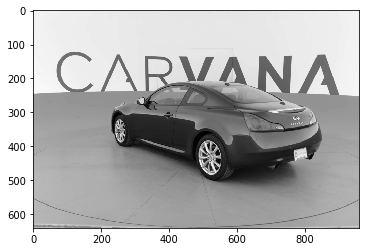

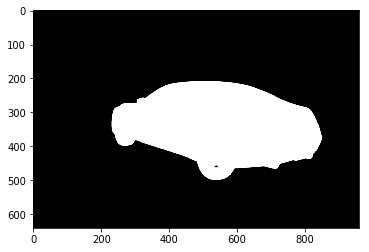

In [3]:
# Test Images
mask = np.zeros((1280*1918, 1), dtype=np.float32)
for pair in masks[files[0].split("/")[-1]]:
    indices = list(range(pair[0], pair[0]+pair[1]))
    mask[indices] = 1
    
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(imresize(imread(files[0], flatten=True), 50), cmap="gray")
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(imresize(mask.reshape((1280, 1918)), 50), cmap="gray")

In [4]:
print(imresize(imread(files[0], flatten=True), 50).shape)

(640, 959)


In [ ]:
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, shape=[None, 640, 959, 1])
targets_ = tf.placeholder(tf.float32, shape=[None, 640, 959, 1])

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (5, 5), padding='same')
# Now 640x959x16
maxpool1 = tf.nn.relu(tf.layers.max_pooling2d(conv1, 2, 2))
# Now 320x479x16
conv2 = tf.layers.conv2d(maxpool1, 8, (5, 5), padding='same')
# Now 320x479x8
maxpool2 = tf.nn.relu(tf.layers.max_pooling2d(conv2, 2, 2))
# Now 160x239x8
conv3 = tf.layers.conv2d(maxpool2, 8, (5, 5), padding='same')
# Now 160x239x4
encoded = tf.nn.relu(tf.layers.max_pooling2d(conv3, 2, 2), name="encoded")
# Now 80x119x4

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, [160, 239])
# Now 160x239x8
conv4 = tf.layers.conv2d_transpose(upsample1, 8, (5, 5), padding='same')
# Now 160x239x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, [320, 479])
# Now 320x479x8
conv5 = tf.layers.conv2d_transpose(upsample2, 8, (5, 5), padding='same')
# Now 320x479x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, [640, 959])
# Now 640x959x8
conv6 = tf.layers.conv2d_transpose(upsample3, 16, (5, 5), padding='same')
# Now 640x959x16

logits = tf.layers.conv2d_transpose(conv6, 1, (5, 5), padding='same')
# Now 640x959x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name="decoded")

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.0001).minimize(cost)

In [ ]:
import sys

# Hyperparams
batch_size = 40
epoch = 12

# Start a new session to show example output.
sess = tf.Session()
# Required to get the filename matching to run.
sess.run(tf.global_variables_initializer())

for i in range(epoch):
    for batch in range(0, train_size+1, batch_size):
        start = batch
        end = min(batch+batch_size, train_size)
        batch_files = train_files[start:end]

        batch_images = np.zeros((batch_size, 640, 959, 1), dtype=np.float32)
        batch_labels = np.zeros((batch_size, 640, 959, 1), dtype=np.float32)
        for idx, file in enumerate(batch_files):
            batch_images[idx] = imresize(imread(file, flatten=True), 50).reshape((640, 959, 1))/255
            mask = np.zeros((1280*1918,), dtype=np.float32)
            for pair in masks[file.split("/")[-1]]:
                indices = list(range(pair[0], pair[0]+pair[1]))
                mask[indices] = 1
            batch_labels[idx] = imresize(mask.reshape((1280, 1918)), 50).reshape((640, 959, 1))

        _, train_loss = sess.run([opt, cost], feed_dict={inputs_: batch_images, targets_: batch_labels})
        sys.stdout.write("\rTraining loss: " + str(train_loss)[:5])
        sys.stdout.flush()

    val_images = np.zeros((batch_size, 640, 959, 1), dtype=np.float32)
    val_labels = np.zeros((batch_size, 640, 959, 1), dtype=np.float32)
    rand_indices = np.random.choice(len(val_files), batch_size)
    for idx, file in enumerate(val_files[rand_indices]):
        val_images[idx] = imresize(imread(file, flatten=True), 50).reshape((640, 959, 1))/255
        mask = np.zeros((1280*1918,), dtype=np.float32)
        for pair in masks[file.split("/")[-1]]:
            indices = list(range(pair[0], pair[0]+pair[1]))
            mask[indices] = 1
        val_labels[idx] = imresize(mask.reshape((1280, 1918)), 50).reshape((640, 959, 1))

    print("Epoch:", i, "Validation Accuracy:", sess.run(cost, feed_dict={inputs_: val_images, targets_: val_labels}))

Training loss: -98.7

In [ ]:
saver = tf.train.Saver()
saver.save(sess, '/output/carvana-model')